# PDF Roster Data Extractor

This notebook extracts roster data from PDF files and combines them into a single Excel spreadsheet.

## Step 1: Install Required Libraries

First, let's make sure we have all the required libraries installed.

In [ ]:
# Install required packages if they're not already installed
# pip install pandas pdfplumber openpyxl

## Step 2: Import Required Libraries

In [1]:
import os
import re
import pandas as pd
import pdfplumber
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## Step 3: Define Functions to Extract and Process Data

In [2]:
def extract_data_from_pdf(pdf_path):
    """
    Extract roster data from PDF file.
    Returns a pandas DataFrame with columns: Date, Carer, Start time, End time
    """
    print(f"Processing: {pdf_path}")
    
    data = []
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                
                # Skip pages that don't have actual data
                if not re.search(r'Date\s+Carer\s+Start time\s+End time', text):
                    continue
                
                # Extract rows using regex
                rows = re.findall(r'([A-Za-z]+,\s+\d{2}\s+[A-Za-z]+\s+\d{4})\s+([^0-9\n]+?)\s+(\d{2}:\d{2}\s+[AP]M)\s+(\d{2}:\d{2}\s+[AP]M)', text)
                
                for row in rows:
                    date, carer, start_time, end_time = row
                    # Clean up any extra whitespace
                    carer = re.sub(r'\s+', ' ', carer).strip()
                    
                    data.append({
                        'Date': date.strip(),
                        'Carer': carer.strip(),
                        'Start time': start_time.strip(),
                        'End time': end_time.strip()
                    })
                    
    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")
    
    return pd.DataFrame(data)

def process_directory(directory_path):
    """
    Scan the directory for PDF files, process each one, and return a combined DataFrame.
    """
    combined_df = pd.DataFrame()
    
    # Sort PDF files to ensure they're processed in a consistent order
    pdf_files = sorted([f for f in os.listdir(directory_path) if f.lower().endswith('.pdf')])
    
    if not pdf_files:
        print(f"No PDF files found in {directory_path}")
        return combined_df
    
    print(f"Found {len(pdf_files)} PDF files")
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        df = extract_data_from_pdf(pdf_path)
        
        if not df.empty:
            # Try to extract month/year from the filename or content
            match = re.search(r'([A-Za-z]+)\s+(\d{4})', pdf_file)
            if match:
                month, year = match.groups()
                df['Month'] = month
                df['Year'] = year
            
            # Add source filename
            df['Source File'] = pdf_file
            
            # Append to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # Sort the combined DataFrame by date if possible
    if not combined_df.empty:
        try:
            combined_df['Date_Parsed'] = pd.to_datetime(combined_df['Date'], format='%a, %d %b %Y')
            combined_df = combined_df.sort_values('Date_Parsed')
            combined_df = combined_df.drop('Date_Parsed', axis=1)
        except Exception as e:
            print(f"Warning: Could not sort by date: {str(e)}")
    
    return combined_df

## Step 4: Set Download Directory and Process PDFs

Now we'll look for PDFs in the downloads directory and process them.

In [3]:
# Set the download directory - modify this path if needed
# This assumes the notebook is running on your desktop system
import os

# Detect operating system and set downloads directory accordingly
import platform
system = platform.system()

if system == 'Windows':
    downloads_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
elif system == 'Darwin':  # macOS
    downloads_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
else:  # Linux and others
    downloads_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

print(f"Looking for PDFs in: {downloads_dir}")

# Check if the directory exists
if not os.path.isdir(downloads_dir):
    print(f"Warning: {downloads_dir} directory not found!")
else:
    # List PDF files in the directory
    pdf_files = [f for f in os.listdir(downloads_dir) if f.lower().endswith('.pdf')]
    print(f"Found {len(pdf_files)} PDF files:")
    for pdf in pdf_files:
        print(f"  - {pdf}")

Looking for PDFs in: /Users/byron/Downloads
Found 2 PDF files:
  - Dilon Higgins-ShiftCare (February).pdf
  - Dilon Higgins-ShiftCare (January).pdf


## Step 5: Process the PDFs and Extract Data

In [4]:
# Process all PDFs in the downloads directory
combined_df = process_directory(downloads_dir)

# Show the number of records extracted
if not combined_df.empty:
    print(f"Extracted {len(combined_df)} roster entries from the PDFs")
    display(combined_df.head())
else:
    print("No data was extracted from the PDF files")

Found 2 PDF files
Processing: /Users/byron/Downloads/Dilon Higgins-ShiftCare (February).pdf
Processing: /Users/byron/Downloads/Dilon Higgins-ShiftCare (January).pdf
Extracted 284 roster entries from the PDFs


,Date,Carer,Start time,End time,Source File
134,"Tue, 31 Dec 2024",Judith Jelagat,23:00 PM,07:00 AM,Dilon Higgins-ShiftCare (January).pdf
138,"Wed, 01 Jan 2025",Brianna Fraser,23:00 PM,07:00 AM,Dilon Higgins-ShiftCare (January).pdf
137,"Wed, 01 Jan 2025",Jacob Mark Bombeo,15:00 PM,23:00 PM,Dilon Higgins-ShiftCare (January).pdf
136,"Wed, 01 Jan 2025",Social Ability,11:00 AM,20:00 PM,Dilon Higgins-ShiftCare (January).pdf
135,"Wed, 01 Jan 2025",Allan Kipchoge Rotich,07:00 AM,18:00 PM,Dilon Higgins-ShiftCare (January).pdf


## Step 6: Basic Data Analysis

Let's perform some basic analysis on the extracted data.

Top 10 Carers by Number of Shifts:


Social Ability           33
Allan Kipchoge Rotich    29
Brianna Fraser           28
Maureen Jerotich         27
Judith Jelagat           24
Jacob Mark Bombeo        24
Client Housing           22
Tristan Daryl Agra       17
Abrahim Kabout           17
Nobert Chibuike Obi      13
Name: Carer, dtype: int64

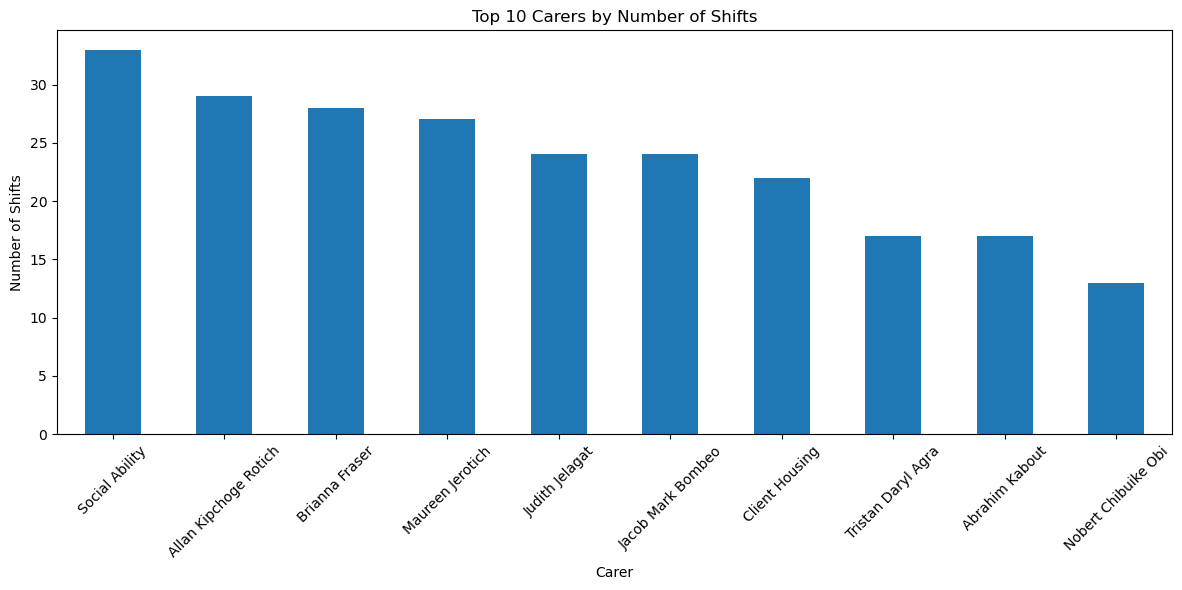

In [5]:
if not combined_df.empty:
    # Count of shifts per carer
    carer_counts = combined_df['Carer'].value_counts()
    
    # Display top 10 carers by number of shifts
    print("Top 10 Carers by Number of Shifts:")
    display(carer_counts.head(10))
    
    # Plot the top 10 carers
    plt.figure(figsize=(12, 6))
    carer_counts.head(10).plot(kind='bar')
    plt.title('Top 10 Carers by Number of Shifts')
    plt.xlabel('Carer')
    plt.ylabel('Number of Shifts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Step 7: Save the Data to Excel

Finally, let's save the combined data to an Excel file in the downloads directory.

In [6]:
if not combined_df.empty:
    # Create the output filename in the downloads directory
    output_filename = os.path.join(downloads_dir, 'combined_roster_data.xlsx')
    
    try:
        # Save the DataFrame to Excel
        combined_df.to_excel(output_filename, index=False)
        print(f"Data successfully saved to {output_filename}")
    except Exception as e:
        print(f"Error saving Excel file: {str(e)}")
else:
    print("No data to save")

Data successfully saved to /Users/byron/Downloads/combined_roster_data.xlsx


## Optional: Filter or Analyze Data Further

You can use this section to further filter or analyze the extracted data.

In [7]:
# Example: Filter data for a specific carer
if not combined_df.empty:
    # Get a list of unique carers
    unique_carers = combined_df['Carer'].unique()
    print(f"Found {len(unique_carers)} unique carers")
    
    # Example: Filter for one carer (if they exist in the data)
    if len(unique_carers) > 0:
        example_carer = unique_carers[0]
        carer_df = combined_df[combined_df['Carer'] == example_carer]
        print(f"\nShifts for {example_carer}:")
        display(carer_df)

Found 25 unique carers

Shifts for Judith Jelagat:


,Date,Carer,Start time,End time,Source File
134,"Tue, 31 Dec 2024",Judith Jelagat,23:00 PM,07:00 AM,Dilon Higgins-ShiftCare (January).pdf
139,"Thu, 02 Jan 2025",Judith Jelagat,07:00 AM,15:00 PM,Dilon Higgins-ShiftCare (January).pdf
153,"Mon, 06 Jan 2025",Judith Jelagat,07:00 AM,16:00 PM,Dilon Higgins-ShiftCare (January).pdf
168,"Thu, 09 Jan 2025",Judith Jelagat,07:00 AM,15:00 PM,Dilon Higgins-ShiftCare (January).pdf
186,"Mon, 13 Jan 2025",Judith Jelagat,07:00 AM,16:00 PM,Dilon Higgins-ShiftCare (January).pdf
203,"Thu, 16 Jan 2025",Judith Jelagat,07:00 AM,15:00 PM,Dilon Higgins-ShiftCare (January).pdf
221,"Mon, 20 Jan 2025",Judith Jelagat,07:00 AM,16:00 PM,Dilon Higgins-ShiftCare (January).pdf
238,"Thu, 23 Jan 2025",Judith Jelagat,07:00 AM,16:00 PM,Dilon Higgins-ShiftCare (January).pdf
260,"Mon, 27 Jan 2025",Judith Jelagat,23:00 PM,08:00 AM,Dilon Higgins-ShiftCare (January).pdf
256,"Mon, 27 Jan 2025",Judith Jelagat,07:00 AM,16:00 PM,Dilon Higgins-ShiftCare (January).pdf
